# 1- Perkenalan

Nama : Ferdiansyah Ersatiyo

FTDS RMT -020-

Objective : Create computer vision model  to predict car or bike



# 2- Import Library

In [1]:
!pip install kaggle

In [2]:
import os
import glob
import random
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import MaxPool2D, Rescaling
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception,  VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Input

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# 3- Data Loading

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!mkdir ~/.kaggle

# !cp 'kaggle.json' ~/.kaggle
!cp '/content/kaggle.json' ~/.kaggle

!ls ~/.kaggle

kaggle.json


In [5]:
!kaggle datasets download -d utkarshsaxenadn/car-vs-bike-classification-dataset

 99% 102M/103M [00:05<00:00, 22.3MB/s] 
100% 103M/103M [00:05<00:00, 18.0MB/s]


In [6]:
!unzip -q /content/car-vs-bike-classification-dataset.zip -d images

In [7]:
# creating empty dataframe
df = pd.DataFrame(columns=['path','label'])

# making all car images as 0
for dirname, _, filenames in os.walk('/content/images/Car-Bike-Dataset/Car'):
  for filename in filenames:
    df = df.append(pd.DataFrame([[os.path.join(dirname, filename),'Car']],columns=['path','label']))

# making all bike images as 1
for dirname, _, filenames in os.walk('/content/images/Car-Bike-Dataset/Bike'):
  for filename in filenames:
    df = df.append(pd.DataFrame([[os.path.join(dirname, filename),'Bike']],columns=['path','label']))

# Reseting index
df = df.sample(frac=1).reset_index(drop=True)

# Display
df.head(10)


,path,label
0,/content/images/Car-Bike-Dataset/Car/Car (1684...,Car
1,/content/images/Car-Bike-Dataset/Car/Car (1667...,Car
2,/content/images/Car-Bike-Dataset/Bike/Bike (15...,Bike
3,/content/images/Car-Bike-Dataset/Car/Car (1421...,Car
4,/content/images/Car-Bike-Dataset/Bike/Bike (27...,Bike
5,/content/images/Car-Bike-Dataset/Bike/Bike (98...,Bike
6,/content/images/Car-Bike-Dataset/Bike/Bike (43...,Bike
7,/content/images/Car-Bike-Dataset/Bike/Bike (91...,Bike
8,/content/images/Car-Bike-Dataset/Car/Car (6).png,Car
9,/content/images/Car-Bike-Dataset/Car/Car (406)...,Car


# 4- Expolartory Data Analysis

we chcek if the data cointans non photos file

In [8]:
# check if all the data in images files
dataset_directory = '/content/images'

non_allowed_extensions = ['.jpeg', '.jpg', '.png']

def check_file_extension(filename):
    _, extension = os.path.splitext(filename)
    return extension.lower() not in non_allowed_extensions

non_allowed_files = []

for root, _, files in os.walk(dataset_directory):
    for file in files:
        if check_file_extension(file):
            non_allowed_files.append(os.path.join(root, file))

if len(non_allowed_files) > 0:
    print("Non-JPEG, JPG, and PNG files found in the dataset:")
    for file_path in non_allowed_files:
        print(file_path)
else:
    print("All files in the dataset are JPEG, JPG, or PNG.")

All files in the dataset are JPEG, JPG, or PNG.


## Data distribution

In [9]:
#check duplicated data
df.duplicated().sum()

0

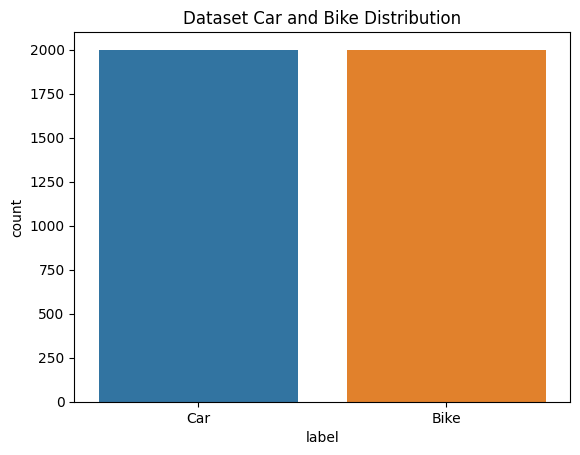

In [10]:
sns.countplot(df,x='label')
plt.title('Dataset Car and Bike Distribution')

plt.show()

we had a balance value between Bike and Car. so we dont have to worry that the data will learn both label as balance

## Show images

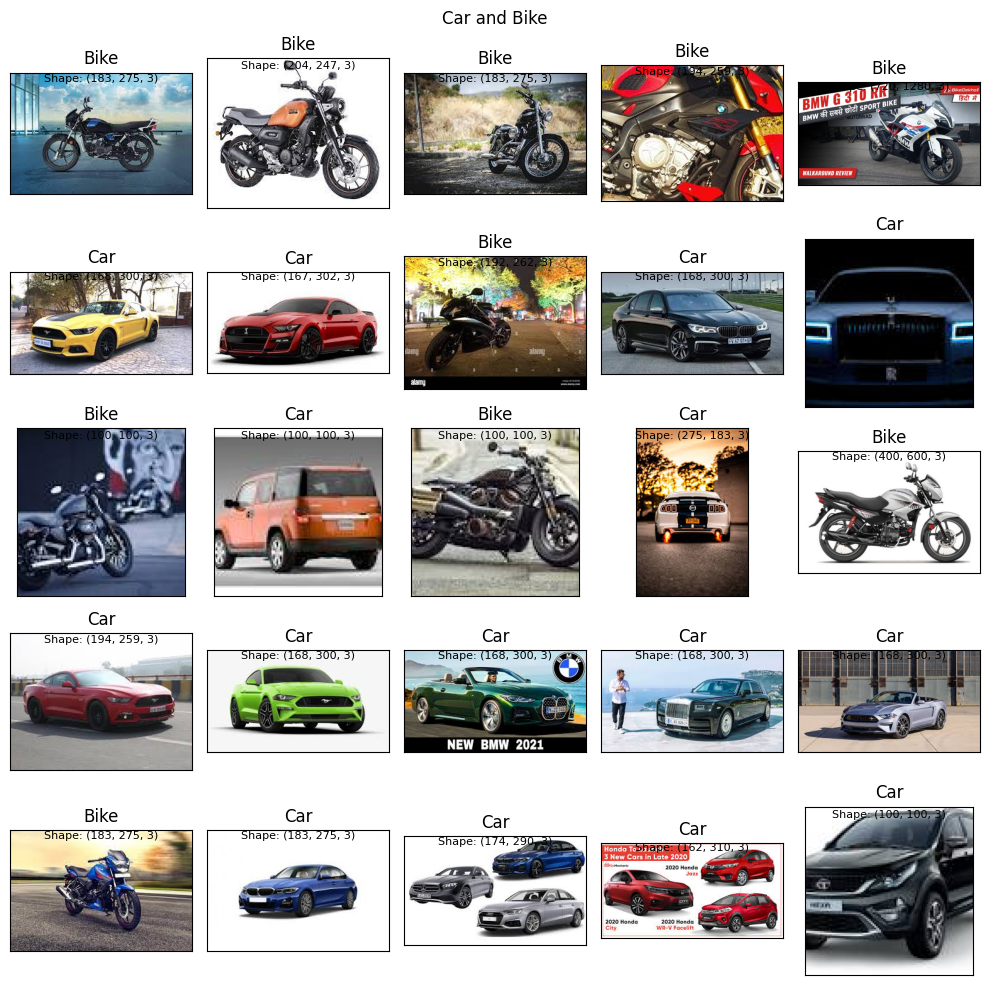

In [11]:
random_index = np.random.randint(0,len(df),30)
fig,axes = plt.subplots(nrows=5,ncols=5,figsize=(10,10),subplot_kw={'xticks':[],'yticks':[]})
plt.suptitle('Car and Bike')

for i,ax in enumerate(axes.flat):
  img = plt.imread(df['path'].iloc[random_index[i]])
  ax.imshow(img)
  ax.set_title(df['label'].iloc[random_index[i]])

   # Print the image shape
  img_shape = img.shape
  ax.text(0.5, 0.95, f"Shape: {img_shape}", transform=ax.transAxes, fontsize=8, ha='center', va='center')

plt.tight_layout()
plt.show()

We see here that our dataset of picture contains various image size and also differennt angle and different parts of the specific labels. Theres a picture that is horizontal and vertical and also a picture from adverstisment, different in image size will be a problem in our modelling if we do not change all the images to the same size.

We have rgb images

## Edge Detection

we want to see how computer see our images using edge detection,to use edge detection were going to change our picture to greyscale because we have rgb picture dataset

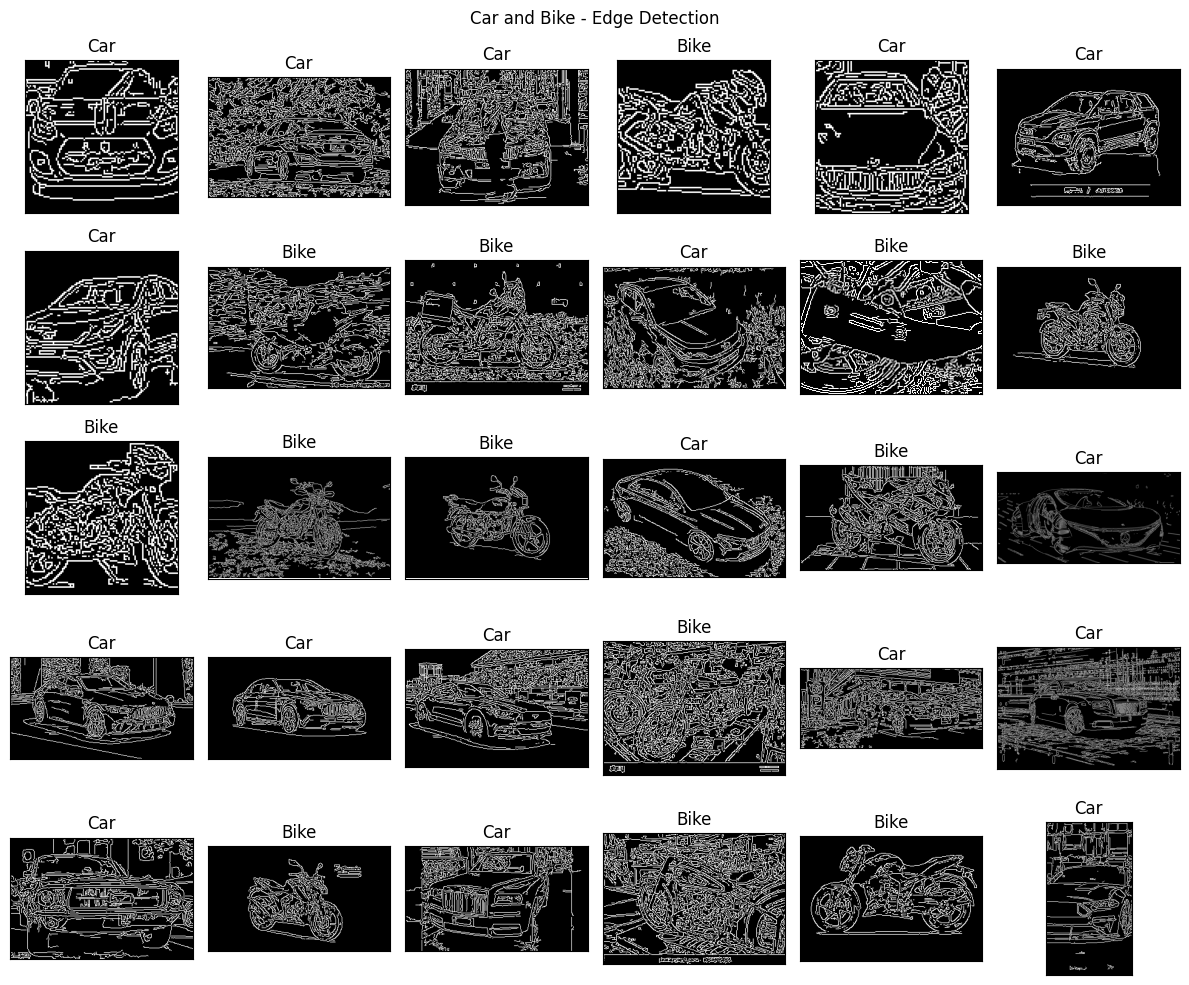

In [13]:
random_index = np.random.randint(0, len(df), 30)
fig, axes = plt.subplots(nrows=5, ncols=6, figsize=(12, 10), subplot_kw={'xticks': [], 'yticks': []})
plt.suptitle('Car and Bike - Edge Detection')

for i, ax in enumerate(axes.flat):
    img_path = df['path'].iloc[random_index[i]]
    img = plt.imread(img_path)

    # Convert the image to grayscale for edge detection
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Perform Canny edge detection
    edges = cv2.Canny(gray_img, 50, 150)

    ax.imshow(edges, cmap='gray')
    ax.set_title(df['label'].iloc[random_index[i]])

plt.tight_layout()
plt.show()

if we use our naked eye its more easy to see a car rather than a Bike

## EDA Insight

1. Theres is 2 class in this dataset which is car and bike(motorcycle)
2. The distribution between car and bike is balance
3. Images in dataset had various size
4. Images in dataset is rgb
5. Images in dataset have various angle taken but i dont see any from top pov
6. Theres also a zoom picture to specific parts of the class such as lamps,wheel,speedometer etc
7. Both class have light and dark vehicles
8. Car have 4 wheels and bike only have 2 wheels
9. Car is more bigger in size than a bike

# 5- Feature Engineering

## Splitting data

In [14]:
# Splitting dataset
# Train, val and tes
valset , test = train_test_split(df, test_size=0.1  , random_state=42)
train, val = train_test_split(valset, test_size=0.2 , random_state=42)

# Check shape of data
print('Train-set Shape : ', train.shape)
print('Validation-set Shape : ', val.shape)
print('Test-set Shape : ', test.shape)

Train-set Shape :  (2880, 2)
Validation-set Shape :  (720, 2)
Test-set Shape :  (400, 2)


## Preprocessing

### Set Height and Width

we set our images to 200 x 200 so it'll be same with all of the images and making easier to analyze

In [15]:
img_height= 200
img_width= 200

### Data Augmentation

we will do augmentation to our data with

*   Rescale = normalize the pixel values of the images. By dividing all pixel values by 255, the pixel values are scaled to the range [0, 1]
*   widht_shift_range = shifting the width of the image horizontally
*   height_shift_range =  shifting the height of the image vertically
*   vertical_flip = flip the images vertically
*   on the validation and test set we only rescale our images



In [16]:
#For train
datagen = ImageDataGenerator(rescale=1./255,
                             width_shift_range=0.15,
                             height_shift_range=0.15,
                             vertical_flip=True)


# For test
datagen_test = ImageDataGenerator(rescale=1./255)

## Tensorflow Pipeline

Create a tensorflow pipeline to easier training the model

In [17]:
train_set = datagen.flow_from_dataframe(dataframe=train,
                                        x_col='path',
                                        y_col='label',
                                        batch_size=32,
                                        target_size=(img_height, img_width),
                                        shuffle=True,
                                        seed=42,
                                        class_mode='binary'
                                        )

val_set = datagen_test.flow_from_dataframe(dataframe=val,
                                        x_col='path',
                                        y_col='label',
                                        batch_size=32,
                                        target_size=(img_height, img_width),
                                        shuffle=True,
                                        seed=42,
                                        class_mode='binary'
                                        )

test_set = datagen_test.flow_from_dataframe(dataframe=test,
                                        x_col='path',
                                        y_col='label',
                                        batch_size=32,
                                        target_size=(img_height, img_width),
                                        shuffle=False,
                                        seed=42,
                                        class_mode='binary'
                                        )

Found 2880 validated image filenames belonging to 2 classes.
Found 720 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.


In [18]:
train_set.class_indices

{'Bike': 0, 'Car': 1}

# 6- Modeling

## Base Model

Were going to use sequential model in this case because the flow of cnn is one way from input to output. This design is well-suited for most cases of feedforward neural networks, including CNNs, where data typically flows in one direction, and the output of one layer is the input of the next layer.

In [19]:
# Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [20]:
inputs= (img_height, img_width,3)
model = Sequential()

# Conv2D layers
model.add(Conv2D(25 ,3 , activation='relu',input_shape=inputs)),
model.add(MaxPooling2D()),

# Conv2D layers
model.add(Conv2D(50 ,3 , activation='relu')),
model.add(MaxPooling2D()),

# Conv2D layers
model.add(Conv2D(100 ,3 , activation='relu')),
model.add(MaxPooling2D()),

#flatten
model.add(Flatten()),

model.add(Dense(64, activation='relu')) #hidden1
model.add(Dense(32, activation='relu')) #hidden2

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
              metrics = ['accuracy'])

# Summary model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 25)      700       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 25)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 50)        11300     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 50)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 100)       45100     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 100)      0

I build this architecture using Sequential Model

1. Convolutional first layer with 25 filters,kernel_size=3and activation relu
2. Use MaxPooling with default parameters
3. Convolutional second layer with 50 filters,kernel_size=3 and activation relu
4. Use MaxPooling with with default parameters
5. Convolutional second layer with 100 filters,kernel_size=3 and activation relu
6. Use MaxPooling with with default parameters
7. Flatten to be 1 array
8. Use hidden layer 1 with 64 inputs and activation relu
9. Use hidden layer 2 with 32 inputs and activation relu
10. Use 1 neuron because this is binary classification
11. Compile the model
12. Use binary cross entropy, metrics accuracy and optimizer adam

In [21]:
# Set Callback
callback = EarlyStopping(monitor = 'val_loss',
                          patience = 3,
                          restore_best_weights=True)

## Train Base Model

In [22]:
%%time
history = model.fit(train_set,
                    epochs=50,
                    validation_data= val_set,
                    callbacks= callback)

Epoch 1/50
90/90 [==============================] - 53s 440ms/step - loss: 0.6386 - accuracy: 0.6184 - val_loss: 0.5940 - val_accuracy: 0.6472
Epoch 2/50
90/90 [==============================] - 34s 374ms/step - loss: 0.4196 - accuracy: 0.8035 - val_loss: 0.2690 - val_accuracy: 0.8833
Epoch 3/50
90/90 [==============================] - 34s 383ms/step - loss: 0.3509 - accuracy: 0.8486 - val_loss: 0.2393 - val_accuracy: 0.8903
Epoch 4/50
90/90 [==============================] - 35s 388ms/step - loss: 0.2842 - accuracy: 0.8892 - val_loss: 0.2287 - val_accuracy: 0.9069
Epoch 5/50
90/90 [==============================] - 40s 446ms/step - loss: 0.2660 - accuracy: 0.8948 - val_loss: 0.2506 - val_accuracy: 0.9028
Epoch 6/50
90/90 [==============================] - 35s 385ms/step - loss: 0.2155 - accuracy: 0.9170 - val_loss: 0.2895 - val_accuracy: 0.9028
Epoch 7/50
90/90 [==============================] - 36s 406ms/step - loss: 0.2172 - accuracy: 0.9184 - val_loss: 0.2598 - val_accuracy: 0.9153

In [23]:
#function to plot model accuracy and loss
def plot_training_history(history):
    epochs = len(history.history['accuracy'])
    epochs_range = range(1, epochs + 1)

    # Extracting the training and validation accuracy and loss from the history object
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Plotting the Training and Validation Accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    # Plotting the Training and Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.show()


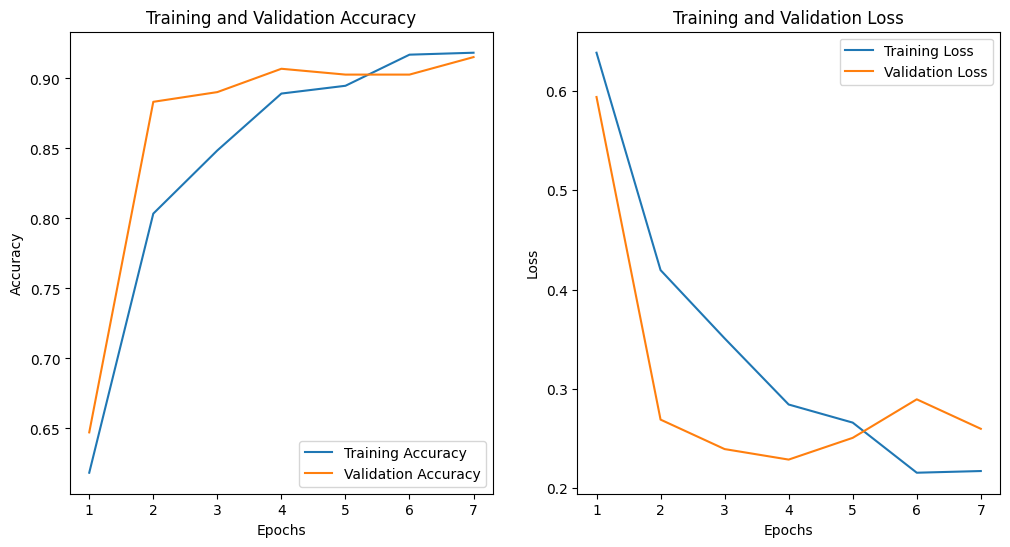

In [24]:
plot_training_history(history)

In [25]:
test_results = model.evaluate(test_set, verbose=0)
print(f'Test Loss     : {test_results[0]:.4f}')
print(f'Test Accuracy : {test_results[1]:.4f}')

Test Loss     : 0.2206
Test Accuracy : 0.9150


This model is overfitt because it cross on the validation and training

the model has 91% accuracy and 22% loss

# 7- Model Improvement

> **Xception** is a deep learning model architecture that was introduced in a research paper titled "Xception: Deep Learning with Depthwise Separable Convolutions" by François Chollet. The paper was published in 2017 and proposed a novel approach for designing convolutional neural networks (CNNs) that achieved state-of-the-art results on various computer vision tasks.

The name "Xception" is derived from "Extreme Inception" and signifies its relationship to the Inception architecture, which was introduced earlier. Xception builds upon the Inception architecture and improves the efficiency of the convolutional layers.

Benefits of Xception:

* Xception achieves state-of-the-art performance on various benchmark datasets,
including ImageNet classification and COCO object detection tasks.
* The use of depthwise separable convolutions results in a more computationally efficient model without sacrificing accuracy.
* It has a modular and flexible architecture, making it easier to adapt to different tasks and datasets.

## Xception

In [26]:
# Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [27]:
pretrained_model = Xception(include_top=False,
                            input_shape=inputs,
                            pooling='avg')
pretrained_model.trainable = False

83683744/83683744 [==============================] - 5s 0us/step


include_top = False berati tidak menggunakan fully connected layer

pretrained_model.trainable = False artinya saya menggunakan bobot model yg sudah dilatih agar tidak dilatih ulang.

In [28]:
model_ex = Sequential()
model_ex.add(pretrained_model)

#fully connected layer
model_ex.add(Flatten())
model_ex.add(Dense(128, activation='relu'))
model_ex.add(Dropout(0.25))
model_ex.add(Dense(64, activation='relu'))
model_ex.add(Dropout(0.25))
model_ex.add(Dense(units=1,activation='sigmoid'))

model_ex.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])
model_ex.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 6

I build this architecture using Xception model and Sequential Model

1. we add the pretrained model to our sequential model
2. flatten the model into 1 array
3. we add fully connected layer
4. add first hidden layer with 128 neuorns and activation relu
5. we add dropout to decrease the possibilty off overfitting the model with the value of 0.25
6. add second hidden layer with 64 neurons and activation relu
7. we add dropout to decrease the possibilty off overfitting the model with the value of 0.25
8. we add our output layers with 1 neuorns and activation sigmoid

## Train Xception

In [29]:
%%time
history1 = model_ex.fit(train_set,
                    epochs=50,
                    validation_data= val_set,
                    callbacks= callback)

Epoch 1/50
90/90 [==============================] - 46s 450ms/step - loss: 0.1263 - accuracy: 0.9521 - val_loss: 0.0347 - val_accuracy: 0.9889
Epoch 2/50
90/90 [==============================] - 38s 424ms/step - loss: 0.0782 - accuracy: 0.9694 - val_loss: 0.0458 - val_accuracy: 0.9861
Epoch 3/50
90/90 [==============================] - 42s 465ms/step - loss: 0.0663 - accuracy: 0.9767 - val_loss: 0.0319 - val_accuracy: 0.9917
Epoch 4/50
90/90 [==============================] - 40s 442ms/step - loss: 0.0472 - accuracy: 0.9819 - val_loss: 0.0390 - val_accuracy: 0.9903
Epoch 5/50
90/90 [==============================] - 42s 467ms/step - loss: 0.0451 - accuracy: 0.9868 - val_loss: 0.0352 - val_accuracy: 0.9917
Epoch 6/50
90/90 [==============================] - 41s 452ms/step - loss: 0.0523 - accuracy: 0.9830 - val_loss: 0.0294 - val_accuracy: 0.9931
Epoch 7/50
90/90 [==============================] - 38s 418ms/step - loss: 0.0448 - accuracy: 0.9826 - val_loss: 0.0349 - val_accuracy: 0.9917

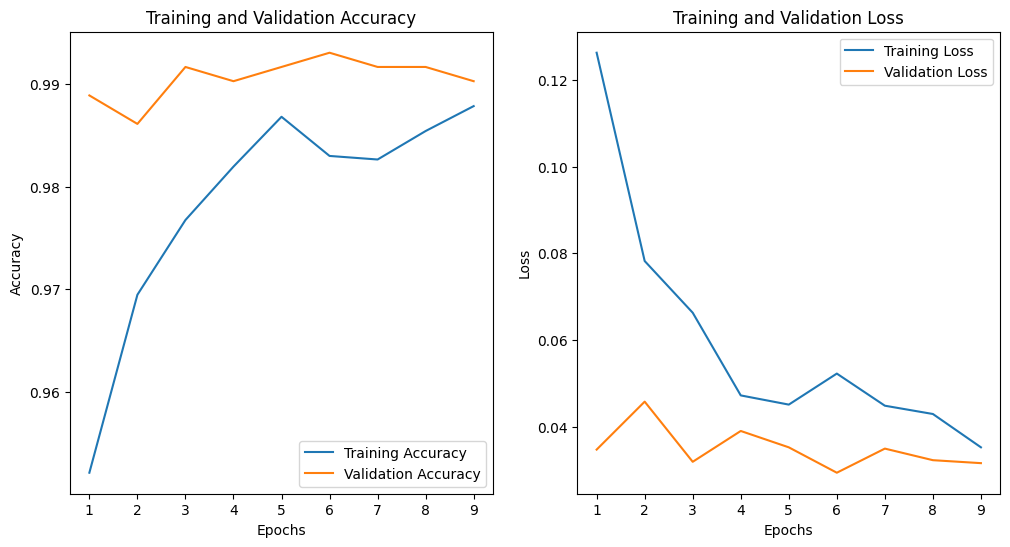

In [30]:
plot_training_history(history1)

In [31]:
test_results = model_ex.evaluate(test_set, verbose=0)
print(f'Test Loss     : {test_results[0]:.4f}')
print(f'Test Accuracy : {test_results[1]:.4f}')

Test Loss     : 0.0223
Test Accuracy : 0.9975


The Model is Good fit because the training and validation is close but not crossing each other

the model has 99% accuracy and 1% loss

## VGG19

> **VGG19** is a deep convolutional neural network architecture that was proposed by the Visual Geometry Group (VGG) at the University of Oxford. It is an extension of the original VGG16 architecture, designed by Simonyan and Zisserman in 2014. VGG19 is known for its simplicity and uniformity, with all convolutional layers using small 3x3 filters and max-pooling layers for downsampling.

Advantages of VGG19:

* Simplicity: VGG19 has a straightforward architecture with a consistent design, making it easy to understand and modify.
* Effective Feature Learning: The small 3x3 filters help the network learn local patterns, and the stacking of multiple convolutional layers allows VGG19 to learn complex features effectively.

Disadvantages of VGG19:

* Computational Complexity: Due to its deep architecture with many parameters, VGG19 is computationally expensive to train and requires substantial computational resources.
* Overfitting: VGG19 may suffer from overfitting, especially when trained on smaller datasets. Techniques like dropout and regularization are often used to mitigate this.

In [32]:
# Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [33]:
pretrained_model1 =  VGG19(include_top=False,
                            input_shape=inputs,
                            pooling='max')
pretrained_model1.trainable = False

80134624/80134624 [==============================] - 4s 0us/step


In [34]:
model_vgg = Sequential()
model_vgg.add(pretrained_model1)

#fully connected layer
model_vgg.add(Flatten())
model_vgg.add(Dense(128, activation='relu'))
model_vgg.add(Dropout(0.25))
model_vgg.add(Dense(32, activation='relu'))
model_vgg.add(Dropout(0.25))
model_vgg.add(Dense(units=1,activation='sigmoid'))

model_vgg.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])
model_vgg.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 3

I build this architecture using VGG19 model and Sequential Model

1. we add the pretrained model to our sequential model
2. flatten the model into 1 array
3. we add fully connected layer
4. add first hidden layer with 128 neuorns and activation relu
5. we add dropout to decrease the possibilty off overfitting the model with the value of 0.25
6. add second hidden layer with 32 neurons and activation relu
7. we add dropout to decrease the possibilty off overfitting the model with the value of 0.25
8. we add our output layers with 1 neuorns and activation sigmoid

## Train VGG19

In [35]:
%%time
history2 = model_vgg.fit(train_set,
                    epochs=50,
                    validation_data= val_set,
                    callbacks= callback)

Epoch 1/50
90/90 [==============================] - 49s 479ms/step - loss: 0.3421 - accuracy: 0.8427 - val_loss: 0.1537 - val_accuracy: 0.9375
Epoch 2/50
90/90 [==============================] - 43s 474ms/step - loss: 0.1718 - accuracy: 0.9323 - val_loss: 0.1013 - val_accuracy: 0.9556
Epoch 3/50
90/90 [==============================] - 40s 445ms/step - loss: 0.1490 - accuracy: 0.9455 - val_loss: 0.0973 - val_accuracy: 0.9597
Epoch 4/50
90/90 [==============================] - 39s 428ms/step - loss: 0.1518 - accuracy: 0.9444 - val_loss: 0.0878 - val_accuracy: 0.9611
Epoch 5/50
90/90 [==============================] - 40s 446ms/step - loss: 0.1441 - accuracy: 0.9500 - val_loss: 0.0814 - val_accuracy: 0.9694
Epoch 6/50
90/90 [==============================] - 43s 474ms/step - loss: 0.1198 - accuracy: 0.9552 - val_loss: 0.1189 - val_accuracy: 0.9528
Epoch 7/50
90/90 [==============================] - 40s 449ms/step - loss: 0.1222 - accuracy: 0.9542 - val_loss: 0.0720 - val_accuracy: 0.9722

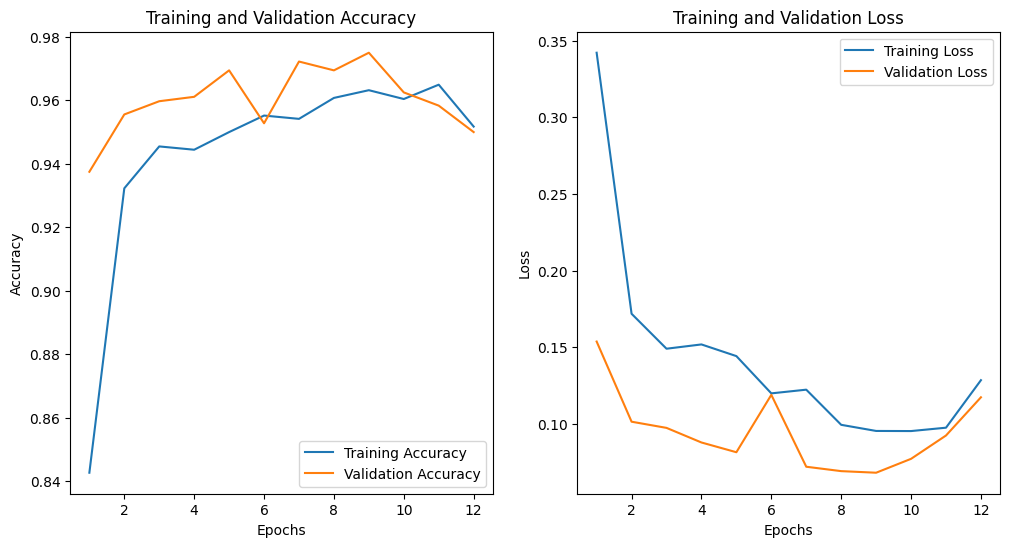

In [36]:
plot_training_history(history2)

In [37]:
test_results = model_vgg.evaluate(test_set, verbose=0)
print(f'Test Loss     : {test_results[0]:.4f}')
print(f'Test Accuracy : {test_results[1]:.4f}')

Test Loss     : 0.1026
Test Accuracy : 0.9600


The Model is good but is quiete over fit, even only 1 line that cross but still overfit, Model have 97% accuracy and 6% loss

# 8- Model Evaluation

## Accuracy and Loss

In [38]:
test_results = model.evaluate(test_set, verbose=0)
print('Base Model Sequential')
print(f'Test Loss     : {test_results[0]:.4f}')
print(f'Test Accuracy : {test_results[1]:.4f}')
print('========================')
test_results = model_ex.evaluate(test_set, verbose=0)
print('Model Improvement using Xception Sequential')
print(f'Test Loss     : {test_results[0]:.4f}')
print(f'Test Accuracy : {test_results[1]:.4f}')
print('========================')
test_results = model_vgg.evaluate(test_set, verbose=0)
print('Model Improvement using VGG Sequential')
print(f'Test Loss     : {test_results[0]:.4f}')
print(f'Test Accuracy : {test_results[1]:.4f}')

Base Model Sequential
Test Loss     : 0.2206
Test Accuracy : 0.9150
Model Improvement using Xception Sequential
Test Loss     : 0.0223
Test Accuracy : 0.9975
Model Improvement using VGG Sequential
Test Loss     : 0.1026
Test Accuracy : 0.9600


## Model Analysis

1. The Base Model has a Test Accuracy of 91%, which means it performs reasonably well on the test dataset but may not be sufficient for some applications where higher accuracy is desired.The Base Model have training time 4min 58s

2. The Xception model shows significant improvement over the Base Model. With a Test Accuracy of 99.7%, it achieves a substantially better performance on the test dataset. Xception is a powerful deep learning architecture known for its efficiency and accuracy, and it seems to be well-suited for the given task. The Xception Model have training time 6min 50s

3. The VGG model also exhibits good performance, with a Test Accuracy of 96%. VGG is a popular and well-established CNN architecture, known for its simplicity and effectiveness in image recognition tasks. The VGG 19 Model have training time 8min 58s VGG is the slowest training time t

# 9- Model Saving

In [39]:
# Freeze Model
model_ex.trainable = False
model_ex.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 6

In [40]:
# Save ANN Model

model_ex.save('model.h5')

# 10- Model Inference

try [here](https://)

# 11- Kesimpulan

The model's ability to learn and recognize intricate visual patterns makes it a valuable tool for various applications in the realm of image classification and object recognition. Through rigorous training, evaluation, and experimentation, we can fine-tune the model to achieve high accuracy and robustness, paving the way for successful deployment in real-world scenarios.